### Time Series Forecast Error 

Compare stability of different errors:

 - norm_mae = normalized_mean_absolute_error
 - norm_rmse = normalized_root_mean_squared_error
 - r2_score
 - spearman_correlation

How to Normalize?
 - by difference between maximum and minimum
 - by standard deviation of the "actual" curve
 - by mean value 
    - arbitrary, will differ if we shift the whole curve up or down
 - by interquartile range (i.e. the difference between 25th and 75th percentile)
    - arbitrary, will differ if we move points between quartile


In [1]:
import os, sys, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
%config InlineBackend.figure_format = 'retina'

In [2]:
!python --version

Python 3.9.12


In [3]:
def fin_err(actual, 
            predicted, 
            norm=None,
            err_type='mae',   # mae or rmse
            noise_level_relative=1e-2,
            noise_level_absolute=1e-2,
            max_error=1e2):
    """
    # calculate relative difference 
    # between two arrays (or lists): actual & predicted
    # fin_err() is similar to normalized_mean_absolute_error
    # but optimized for financial data.
    # It takes into account not only amplitude of oscillations,
    # but also the "level" of values.
    # It also limits maximum error in cases when 
    # actual signal doesn't change much
    # optional parameters:
    #   norm (when provided) used as denominator
    #   noise_level_relative (default 0.01)
    #   noise_level_absolute (default 0.01)
    #   max_error (default 100.0)
    """
    Na, Np = len(actual), len(predicted)
    if Na == 0 or Np == 0 or Na != Np:
        return np.nan
    np_act = np.array(actual, dtype = np.float64)
    np_pre = np.array(predicted, dtype = np.float64)
    if err_type == 'mae': # Mean Absolute Error
        myerr = np.abs(np_act - np_pre).sum() / Na
    elif err_type == 'rmse': # Root Mean Square Error
        myerr = math.sqrt(mean_squared_error(np_act, np_pre)) 
    else:
        print("ERROR: err_type should be 'mae' or 'rmse', exiting ...")
        sys.exit(1)
    if norm and norm > 0: # normalize - and limit
        return min (max_error, myerr / norm )  
    v_max_act, v_min_act = np.max(np_act), np.min(np_act) # max min   
    v_max_pre, v_min_pre = np.max(np_pre), np.min(np_pre) # max min  
    v_amp_act   = v_max_act - v_min_act        # amplitude      
    v_amp_pre   = v_max_pre - v_min_pre        # amplitude      
    v_level_act = np.abs(np_act).sum() / Na    # level             
    v_scale_act = max(v_level_act, v_amp_act)  # level
    v_level_pre = np.abs(np_pre).sum() / Na    # scale             
    v_scale_pre = max(v_level_pre, v_amp_pre)  # scale

    if (v_scale_act <= noise_level_absolute and 
        v_scale_pre <= noise_level_absolute):
            return 0 # actual and predicted are both close to zero 
        
    denom_min = max(v_scale_act * noise_level_relative,
                    noise_level_absolute)
    
    if v_scale_act > denom_min :
        denom = v_scale_act
    else:
        denom = denom_min
    
    return min (max_error, (myerr / denom))

In [4]:
# ----------------------------------------------------
def mape_orig (actual, predicted):
    """
    # calculate mape
    # (Mean Absolute Percentage Error)
    # between two arrays (or lists)
    """
    Na = len(actual)
    Np = len(predicted)
    if Na == 0 or Np == 0 or Na != Np:
        return np.nan
    actual_sum = np.absolute(actual).sum()
    if actual_sum <= 0:
        return np.nan
    mysum = 0
    for ii in range(Na):
        a = actual[ii]
        p = predicted[ii]
        c = a if np.abs(a) != 0 else 0.0001
        v = np.abs((a-p)/c) / Na
        mysum += v
    return mysum

# ----------------------------------------------------
def mape (actual, predicted):
    """
    # calculate mape
    # (Mean Absolute Percentage Error)
    # between two arrays (or lists)
    """
    Na = len(actual)
    Np = len(predicted)
    if Na == 0 or Np == 0 or Na != Np:
        return np.nan
    actual_sum = np.absolute(actual).sum()
    if actual_sum <= 0:
        return np.nan
    mysum = 0
    for ii in range(Na):
        a = actual[ii]
        p = predicted[ii]
        c = a if np.abs(a) > 0.0001 else 0.0001
        v = np.abs((a-p)/c) / Na
        mysum += v
    return mysum

In [9]:
# test fin_err()
mytests = [
     ([0,0,0],[0,0,0]),
     ([1e-4,0,1e-4],[0,1e-4,0]),
     ([0.1,0,0.3],[0,0.1,0]),
     ([0,0,1.001],[0,0,1]),
     ([0,0,0.000],[2000,2,2]),
     ([0,0,0.001],[2000,2,2]),
     ([0,0,0.001],[0,0,0.001]),
     ([10,10,10],[0,0,0.00]),
     ([10,10,10],[0,0,0.001]),
     ([10,10,10],[10,10,10]),
     ([10,10,10],[10.2,10.3,10.2]),
]

# ----------------------------------------------------
def myfmt(x):
    if x != x:
        return "nan"
    if x < 1e-3:
        return "0"
    if abs(1-x) < 1e-3:
        return "1"
    if x > 10:
        return f"{int(x):d}"
    if x > 1:
        return f"{x:.2f}"

    return f"{x:.4f}"
        

df_tests = pd.DataFrame()

for tup in mytests:
    actual = tup[0]
    predic = tup[1]
    a_str = str(actual)
    p_str = str(predic)
    s_fin_err   = myfmt(fin_err(actual,predic))
    s_mape      = myfmt(mape(actual,predic))
    s_mape_orig = myfmt(mape_orig(actual,predic))
    data_dict={"actual":a_str,
               "predicted":[p_str],
               "fin_err":[s_fin_err],
               "mape":[s_mape],
               "mape_orig":[s_mape_orig]}
    # print(data_dict)
    df_tmp = pd.DataFrame(data=data_dict)
    df_tests = pd.concat([df_tests, df_tmp], ignore_index=True)
    # print(tup, f"{fin_err(tup[0],tup[1]):.4f}")
del df_tests['mape_orig']
display(df_tests)

,actual,predicted,fin_err,mape
0,"[0, 0, 0]","[0, 0, 0]",0,nan
1,"[0.0001, 0, 0.0001]","[0, 0.0001, 0]",0,1
2,"[0.1, 0, 0.3]","[0, 0.1, 0]",0.5556,333
3,"[0, 0, 1.001]","[0, 0, 1]",0,0
4,"[0, 0, 0.0]","[2000, 2, 2]",100,nan
5,"[0, 0, 0.001]","[2000, 2, 2]",100,6673999
6,"[0, 0, 0.001]","[0, 0, 0.001]",0,0
7,"[10, 10, 10]","[0, 0, 0.0]",1,1
8,"[10, 10, 10]","[0, 0, 0.001]",1,1
9,"[10, 10, 10]","[10, 10, 10]",0,0


In [10]:
# ----------------------------------------------------
def myscale(x):
    """
    # find reasonable graph scale of positive variable
    """
    if x == 0:
        return 1e-6
    x = np.abs(x)
    n = 0    
    if 0 < x < 1:
        while x < 1:
            n+=1
            x *=10
    elif x >= 10:
        while x >= 10:
            n-=1
            x /=10
    x = 2 * round(x+1)
    return x * ( 10 ** (-n) )   

In [11]:
def plot_comparison(months, vals, levels, err_type='rmse'):
    """
    # plot comparison of different error functions
    """
    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15,3))
    ax0, ax1, ax2, ax3, ax4, ax5 = ax.flatten()
    _ = ax0.set_title(f"actual vs predicted")
    _ = ax1.set_title(f"shifts")
    _ = ax2.set_title(f"MAPE, FIN vs shift")
    _ = ax3.set_title(f"FIN vs shift")
    _ = ax4.set_title(f"R2 vs shift")
    _ = ax5.set_title(f"Spearman vs shift")
    for elem in [ax0,ax1,ax2,ax3,ax4,ax5]:
        _ = elem.grid(True)

    errs_mape = []
    errs_fin = []
    errs_r2 = []
    errs_spea = []
    for level in levels:
        rand_arr = 0.1*(np.random.rand(len(vals))-0.5)
        vals1 = vals+level+rand_arr
        vals2 = vals+level+0.01 # second ("predicted") curve shifted by 10% of amplitude
        if level == 0:
            _ = ax0.plot(months, vals1, color="blue", marker='.')
            _ = ax0.plot(months, vals2, color="green", marker='.')
        _ = ax1.plot(months, vals1, color="blue", marker='.')  
        errs_mape.append(round(mape(vals1,vals2),4))
        errs_fin.append(round(fin_err(vals1,vals2,err_type=err_type),4))
        errs_r2.append(round(r2_score(vals1,vals2),4))
        errs_spea.append(round(stats.spearmanr(vals1,vals2).correlation,4))

    _ = ax2.plot(levels, errs_mape, color="red" , marker='.')
    _ = ax2.plot(levels, errs_fin, color="blue", marker='.')
    _ = ax3.plot(levels, errs_fin, color="blue", marker='.')
    _ = ax4.plot(levels, errs_r2, color="blue", marker='.')
    _ = ax5.plot(levels, errs_spea, color="blue", marker='.')
    _ = ax3.set(ylim=(0.0, myscale(np.max(errs_fin))))
    # _ = ax4.set(ylim=(0.0, myscale(np.max(errs_r2))))

    fig.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=1.0)
    plt.show() ; 


sin() + noise - Mean Absolute Error


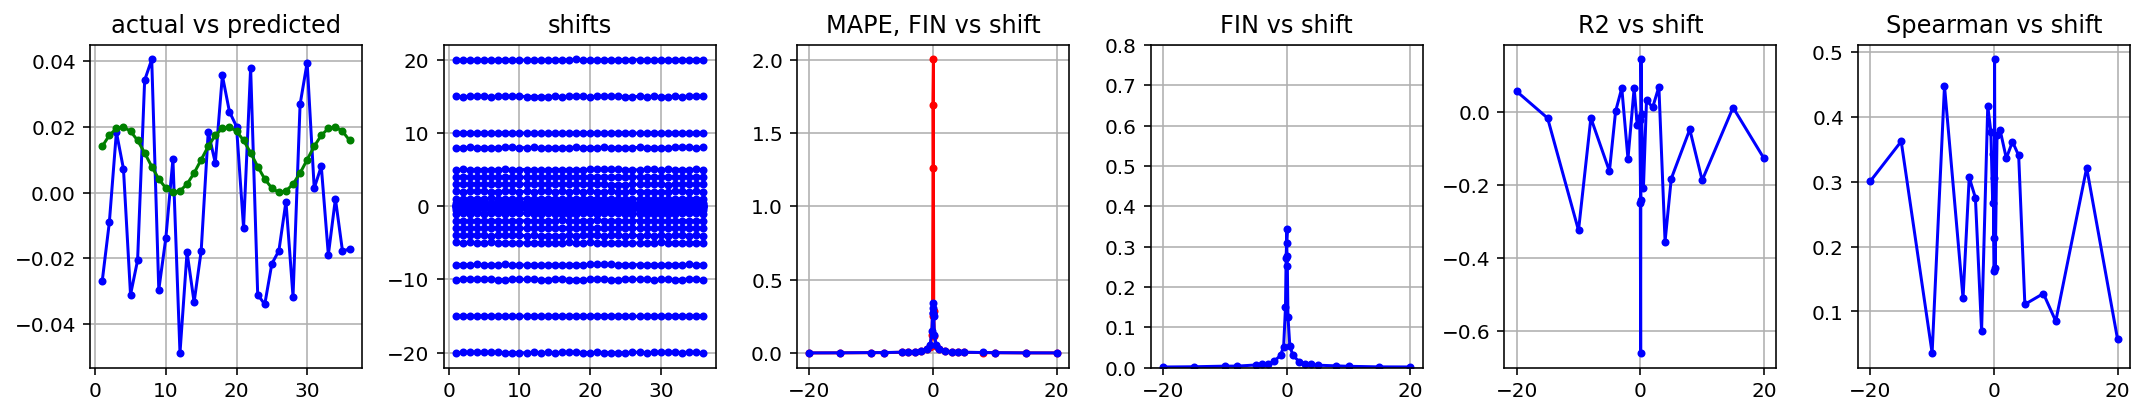


sin() + noise - RMSE


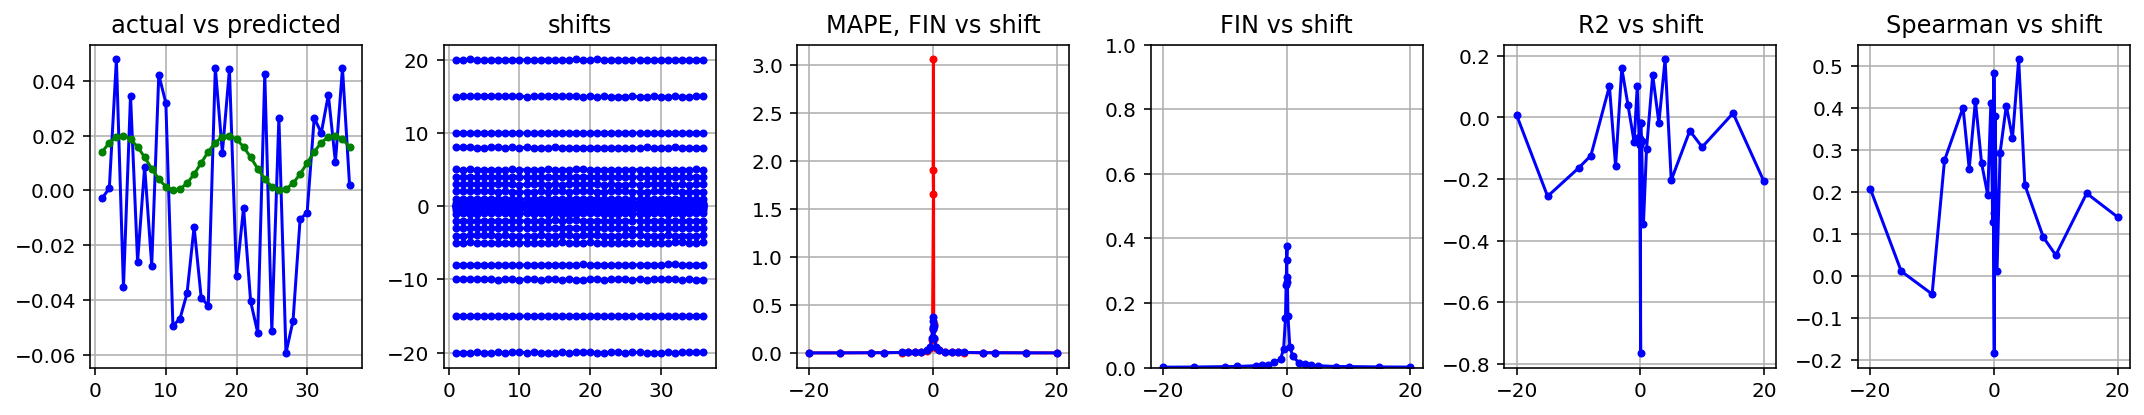


linear + noise


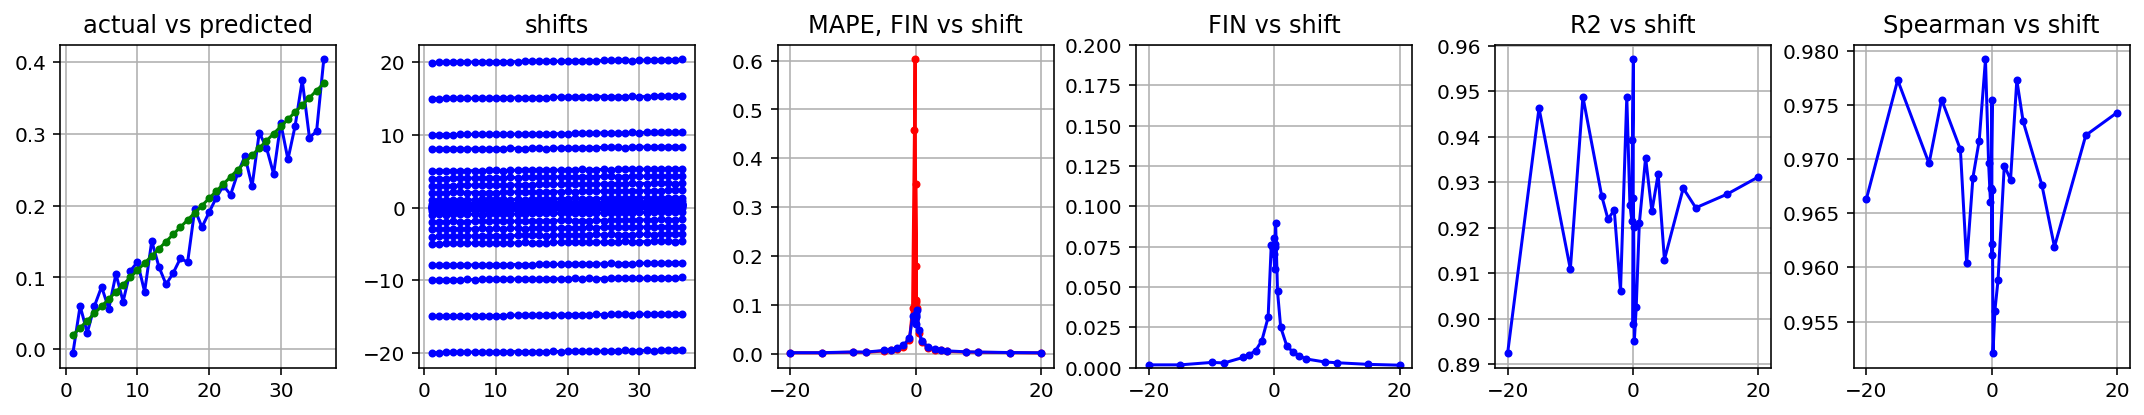

In [12]:
# Visualize different error functions
# for two cases:
#     sin + noise 
#     linear + noise

months = np.arange(1, 37, 1)
levels = [-20,-15,-10,-8,-5,-4,-3,
          -2,-1,-0.5,-0.2,-0.1,0.05,0,0.05,0.1,0.2,0.5,1,2,
          3,4,5,8,10,15,20]

print("\nsin() + noise - Mean Absolute Error")
amp = 0.01
vals   = amp * np.sin(months*2*math.pi/15.0)
plot_comparison(months, vals, levels)

print("\nsin() + noise - RMSE")
amp = 0.01
vals   = amp * np.sin(months*2*math.pi/15.0)
plot_comparison(months, vals, levels, err_type='rmse')

print("\nlinear + noise")
vals   = amp * months
plot_comparison(months, vals, levels)